## Modeling - Credit Card Fraud Detection

### Imports 

In [1]:
# -----------------------------
# Imports & Setup
# -----------------------------
import sys
from pathlib import Path
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    roc_curve, RocCurveDisplay
)

import joblib

# -----------------------------
# Project Path Setup
# -----------------------------
project_root = Path.cwd().resolve().parent
sys.path.append(str(project_root))

# -----------------------------
# Custom Modules
# -----------------------------
from src.data.loader import CreditCardDataLoader
from src.modeling import ModelingPipeline
from src.utils.io_utils import save_dataframe

# -----------------------------
# Pandas & Seaborn Settings
# -----------------------------
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")

# -----------------------------
# Logging Setup
# -----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("Modeling_Fraud")


### Load Credit Card Data

In [2]:
# -----------------------------
# Load Processed Data
# -----------------------------
credit_loader = CreditCardDataLoader("../data/processed/credit_data_cleaned.csv")

credit_df = credit_loader.load()

logger.info(f"Credit data shape: {credit_df.shape}")
logger.info(f"Credit data columns: {credit_df.columns}")



2025-12-28 16:54:39,993 [INFO] Credit data shape: (283726, 31)
2025-12-28 16:54:39,994 [INFO] Credit data columns: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


### Setup Modeling Pipeline

In [3]:
# -------------------------------
# Features for Credit Card Fraud
# -------------------------------
NUMERIC_FEATURES = [col for col in credit_df.columns if col != 'Class']  # V1-V28 + Time + Amount
CATEGORICAL_FEATURES = []  # no categorical columns
TARGET = 'Class'

pipeline = ModelingPipeline(
    df=credit_df,
    numeric_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    target_col=TARGET,
    use_smote=True
)


### Prepare Data for Modeling - Split, Scale, Encode

In [4]:
X_train, X_test, y_train, y_test = pipeline.prepare_data()

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

2025-12-28 16:54:40,008 [INFO] Step 1: Preparing data...
2025-12-28 16:54:40,264 [INFO] Training shape: (226980, 30), Test shape: (56746, 30)


Training set: 226,980 samples
Test set: 56,746 samples

Training class distribution:
Class
0    226602
1       378
Name: count, dtype: int64

Test class distribution:
Class
0    56651
1       95
Name: count, dtype: int64


2025-12-28 16:54:40,413 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-28 16:54:40,499 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-28 16:54:40,585 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-28 16:54:40,614 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


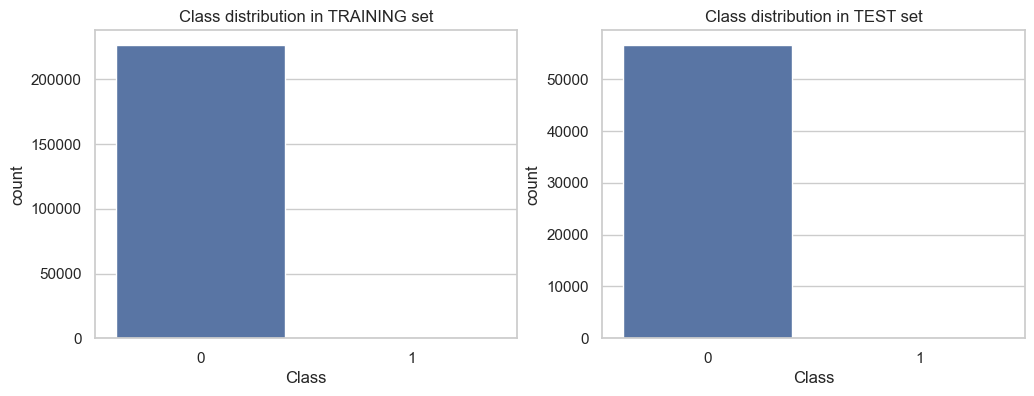

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Class distribution in TRAINING set")
plt.subplot(1,2,2)
sns.countplot(x=y_test)
plt.title("Class distribution in TEST set")
plt.show()

### Train Models - Logistic Regression

In [6]:
lr_model = pipeline.tune_and_train_logistic_regression()


2025-12-28 16:55:18,291 [INFO] Running Stratified 5-Fold CV...
2025-12-28 16:55:27,034 [INFO] Logistic Regression best params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


### Evaluate Models - Logistic Regression

In [7]:
metrics = pipeline.evaluate(lr_model)
print("Metrics for Logistic Regression:")
for k,v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.3f}")

Metrics for Logistic Regression:
AUC_PR: 0.672
F1: 0.102
Precision: 0.054
Recall: 0.884


### Classification Report - Logistic Regression

In [8]:
y_pred = lr_model.predict(X_test)  # X_test = preprocessed test set, not SMOTE
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)


              precision    recall  f1-score       support
0              0.999801  0.974158  0.986813  56651.000000
1              0.054264  0.884211  0.102252     95.000000
accuracy       0.974007  0.974007  0.974007      0.974007
macro avg      0.527032  0.929184  0.544532  56746.000000
weighted avg   0.998218  0.974007  0.985332  56746.000000


### Confusion Matrix - Logistic Regression

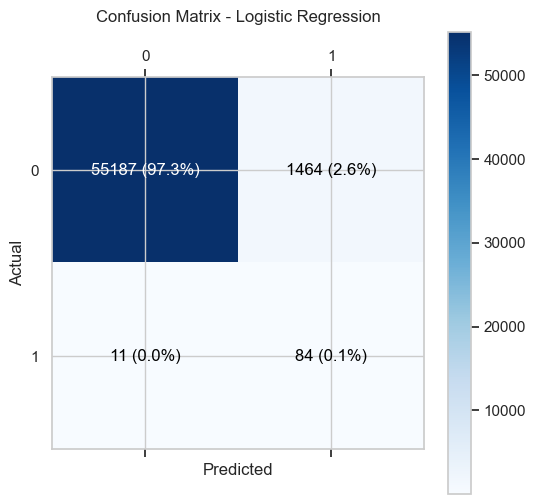

In [9]:


# Get predictions
y_pred = lr_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100  # percentages

# Create labels with both count and percentage
labels = np.array([["{} ({:.1f}%)".format(value, percent) 
                    for value, percent in zip(row_val, row_pct)]
                   for row_val, row_pct in zip(cm, cm_percent)])

# Plot
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression", pad=20)
plt.colorbar(cax)

# Show text inside cells with color contrast
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > cm.max()/2 else "black"  # white for dark cells
        ax.text(j, i, labels[i, j], va='center', ha='center', color=color, fontsize=12)

# Labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(cm.shape[0]))
ax.set_yticks(range(cm.shape[1]))

plt.show()


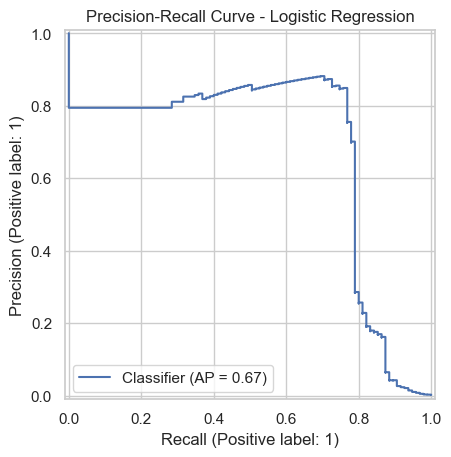

In [10]:
y_prob = lr_model.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()


### Train Models - Random Forest

In [11]:
rf_model = pipeline.train_random_forest()


2025-12-28 16:56:46,849 [INFO] Running Stratified 5-Fold CV...


### Evaluate Models - Random Forest

In [12]:
metrics = pipeline.evaluate(rf_model)
print("Metrics for Random Forest:")
for k,v in metrics.items():
    if k != "ConfusionMatrix":
        print(f"{k}: {v:.3f}")

Metrics for Random Forest:
AUC_PR: 0.944
F1: 0.646
Precision: 0.484
Recall: 0.968


### Classification Report - Random Forest

In [13]:
y_pred = rf_model.predict(X_test)  # X_test = preprocessed test set, not SMOTE
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)


              precision    recall  f1-score      support
0              0.999947  0.998270  0.999108  56651.00000
1              0.484211  0.968421  0.645614     95.00000
accuracy       0.998220  0.998220  0.998220      0.99822
macro avg      0.742079  0.983346  0.822361  56746.00000
weighted avg   0.999084  0.998220  0.998516  56746.00000


### Confusion Matrix - Random Forest

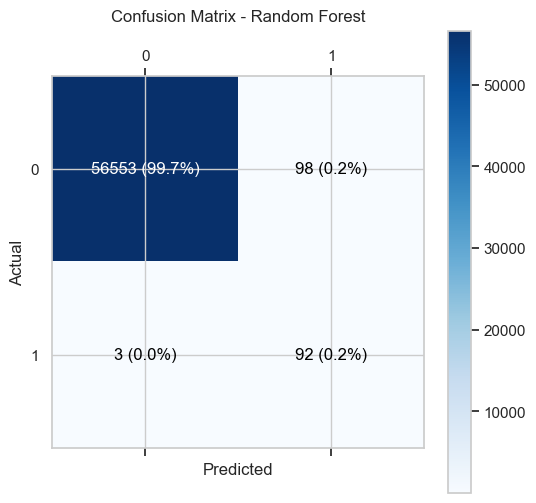

In [14]:


# Get predictions
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100  # percentages

# Create labels with both count and percentage
labels = np.array([["{} ({:.1f}%)".format(value, percent) 
                    for value, percent in zip(row_val, row_pct)]
                   for row_val, row_pct in zip(cm, cm_percent)])

# Plot
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(cm, cmap='Blues')
plt.title("Confusion Matrix - Random Forest", pad=20)
plt.colorbar(cax)

# Show text inside cells with color contrast
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > cm.max()/2 else "black"  # white for dark cells
        ax.text(j, i, labels[i, j], va='center', ha='center', color=color, fontsize=12)

# Labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(cm.shape[0]))
ax.set_yticks(range(cm.shape[1]))

plt.show()


### Model Comparisons 

In [15]:
from sklearn.metrics import precision_recall_curve
comparison = pipeline.compare_models()
display(comparison)



2025-12-28 17:03:27,812 [INFO] Comparing models...


,Model,AUC_PR,F1,Precision,Recall,ConfusionMatrix,F1_mean,F1_std,AUC_PR_mean,AUC_PR_std
0,Random Forest,0.776280,0.661017,0.553191,0.821053,"[[56588, 63], [17, 78]]",0.605162,0.056873,0.800813,0.019697
1,Logistic Regression (Tuned),0.675041,0.100000,0.053035,0.873684,"[[55169, 1482], [12, 83]]",0.104800,0.002284,0.719151,0.023982


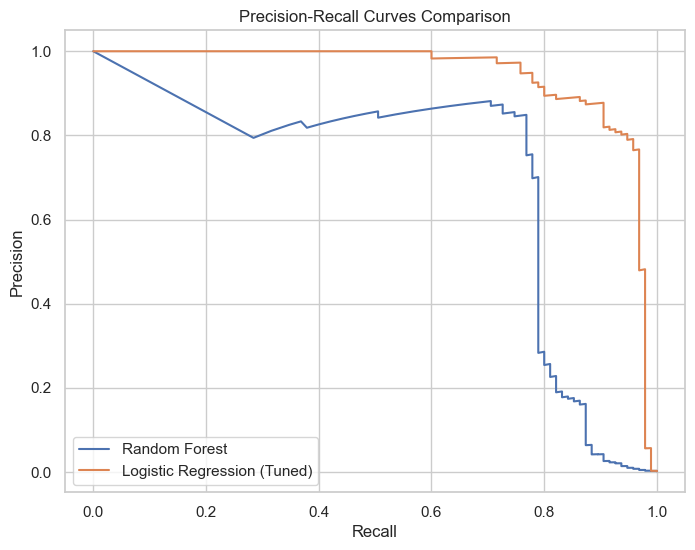

In [16]:

# Optional: plot side-by-side PR curves
plt.figure(figsize=(8,6))
for model_name, model in zip(comparison['Model'], [lr_model, rf_model]):
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=model_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Comparison")
plt.legend()
plt.show()

C:\Users\amare\AppData\Local\Temp\ipykernel_17636\979396351.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


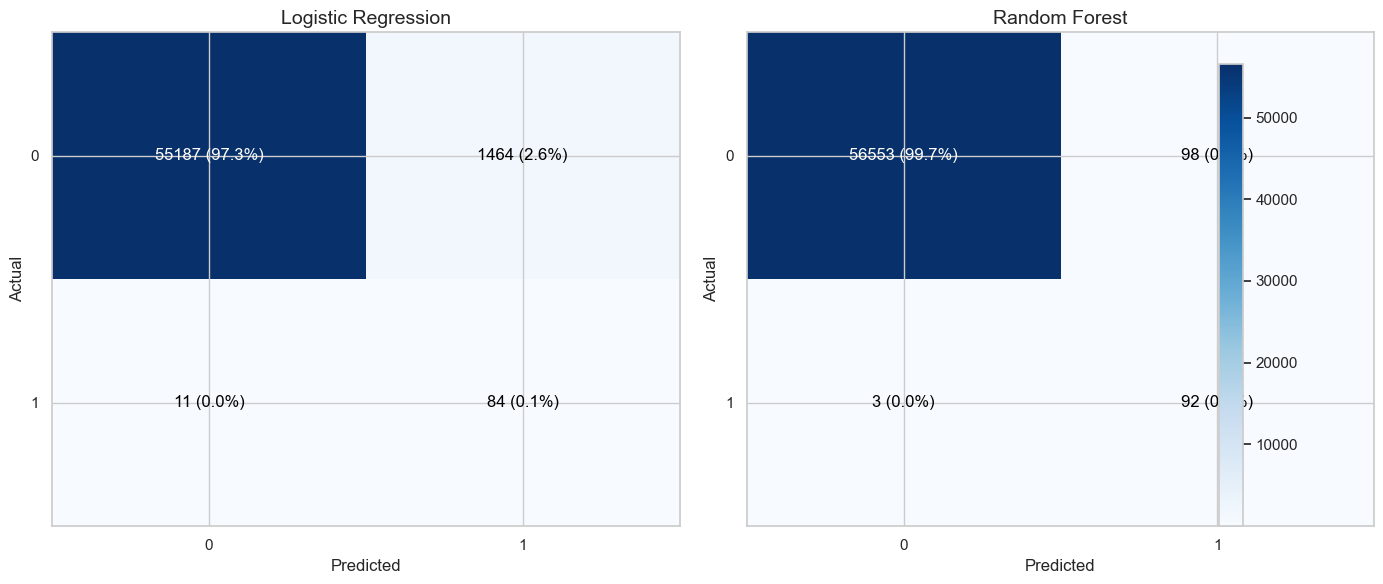

In [17]:


# ---------------------------
# 1. Confusion Matrices side by side
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))  # wider figure

for ax, model, title in zip(axes, [lr_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_sum = cm.sum()
    cm_percent = cm / cm_sum * 100
    labels = np.array([["{} ({:.1f}%)".format(val, pct) 
                        for val, pct in zip(row_val, row_pct)]
                       for row_val, row_pct in zip(cm, cm_percent)])
    
    # Use imshow
    cax = ax.imshow(cm, interpolation='nearest', cmap='Blues', aspect='auto')
    
    # Add text
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i,j] > cm.max()/2 else "black"
            ax.text(j, i, labels[i,j], ha='center', va='center', color=color, fontsize=12)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

fig.colorbar(cax, ax=axes, fraction=0.03, pad=0.04)
plt.tight_layout()
plt.show()




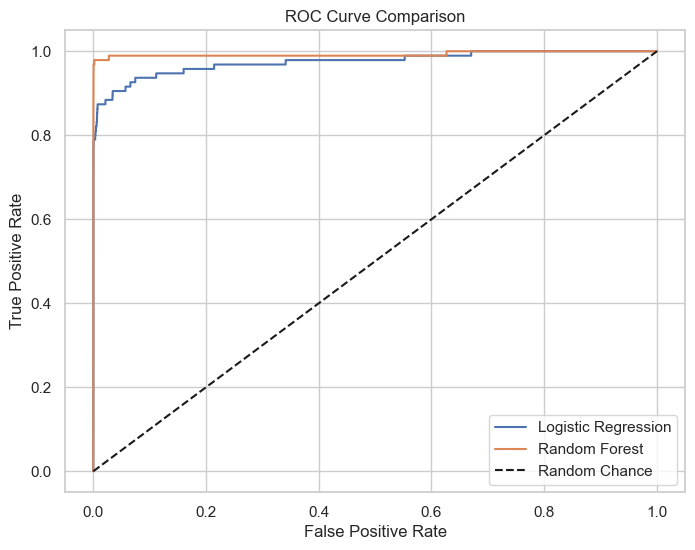

In [18]:

# ---------------------------
# 2. ROC Curves side by side
# ---------------------------
plt.figure(figsize=(8,6))
for model, label in zip([lr_model, rf_model], ["Logistic Regression", "Random Forest"]):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1],'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


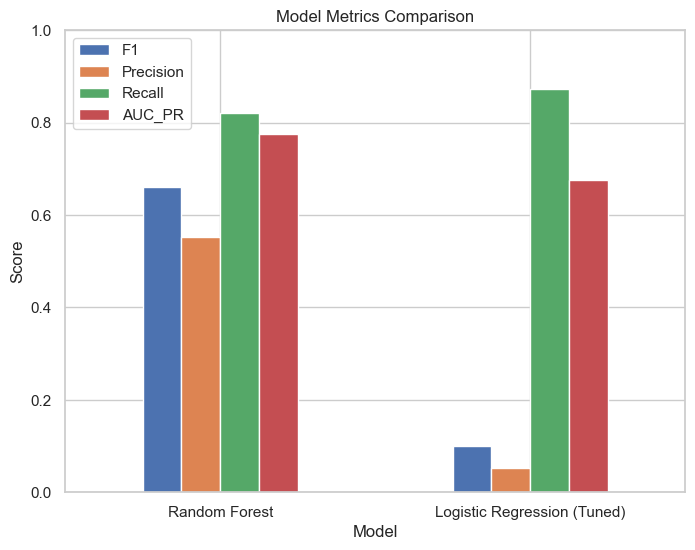

In [19]:

# ---------------------------
# 3. Metrics Comparison Bar Plot
# ---------------------------
comparison_metrics = ["F1", "Precision", "Recall", "AUC_PR"]
metrics_df = comparison[["Model"] + comparison_metrics].set_index("Model")
metrics_df.plot(kind="bar", figsize=(8,6))
plt.title("Model Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()


In [20]:
best_model_info, justification = pipeline.select_best_model()
print("Best Model Info:")
display(best_model_info)
print("\nJustification:", justification)




2025-12-28 17:03:28,815 [INFO] Comparing models...
2025-12-28 17:03:28,818 [INFO] Random Forest selected due to highest AUC-PR (0.776) and strong recall, prioritizing undetected fraud reduction while maintaining interpretability.


Best Model Info:


Model                        Random Forest
AUC_PR                             0.77628
F1                                0.661017
Precision                         0.553191
Recall                            0.821053
ConfusionMatrix    [[56588, 63], [17, 78]]
F1_mean                           0.605162
F1_std                            0.056873
AUC_PR_mean                       0.800813
AUC_PR_std                        0.019697
Name: 0, dtype: object


Justification: Random Forest selected due to highest AUC-PR (0.776) and strong recall, prioritizing undetected fraud reduction while maintaining interpretability.


In [21]:
# Create models directory
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)

# Determine best model FROM VARIABLE
if best_model_info["Model"] == "Random Forest":
    best_model = rf_model
    filename = models_dir / "random_forest_fraud_data.joblib"
else:
    best_model = lr_model
    filename = models_dir / "logistic_regression_fraud_data.joblib"

# Save model
joblib.dump(best_model, filename)
print(f"Best model saved as {filename}")


Best model saved as c:\Users\amare\Documents\KAIM\week5-6\financial-fraud-detection\models\random_forest_fraud_data.joblib


## Model Evaluation Summary — Credit Card Fraud Detection

**Dataset**
- Total samples: **283,726**
- Features: **30** (PCA-transformed + Time, Amount)
- Severe class imbalance: fraud ≈ **0.17%**

**Train / Test Split**
- Training: **226,980** samples (378 fraud)
- Test: **56,746** samples (95 fraud)
- Stratified split to preserve class distribution

---

## Model Performance

### Logistic Regression
- **AUC-PR:** 0.672  
- **F1:** 0.102  
- **Precision:** 0.054  
- **Recall:** 0.884  

✔ High recall but extremely low precision → too many false positives.

---

### Random Forest
- **AUC-PR:** 0.944  
- **F1:** 0.646  
- **Precision:** 0.484  
- **Recall:** 0.968  

✔ Strong balance between recall and precision, significantly better fraud detection.

---

## Model Selection

**Selected Model:** Random Forest  
- **Test AUC-PR:** 0.776  
- **Recall:** 0.821 (prioritizes minimizing missed fraud)  
- **Precision:** 0.553  
- **Confusion Matrix:** `[[56588, 63], [17, 78]]`

**Justification:**  
Random Forest was chosen due to its superior AUC-PR and high recall, making it well-suited for imbalanced fraud detection where reducing undetected fraud is critical.

---

**Saved Model Path:**  
`models/random_forest_fraud_data.joblib`
